In [ ]:
# 필요한 라이브러리 import
import numpy as np
import pandas as pd
import os, random, time
import copy
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import zipfile as zf
from pathlib import Path

from torchvision import datasets, transforms
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import Subset, DataLoader
from PIL import Image

import torch
import torch.nn as nn
from torch.multiprocessing import cpu_count
import torchvision
from torchsummary import summary
import torch.optim as optim
from tqdm import tqdm
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [ ]:
# 구글 드라이브 연동
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import matplotlib.font_manager as fm
!apt-get -qq install fonts-nanum

fe = fm.FontEntry(
    fname=r'/usr/share/fonts/truetype/nanum/NanumGothic.ttf',
    name='NanumGothic')
fm.fontManager.ttflist.insert(0, fe)                                   # Matplotlib에 사용하고자 하는 폰트 추가.
plt.rcParams.update({'font.size': 10, 'font.family': 'NanumGothic'})   # 폰트 설정 (크기는 10으로, 폰트는 나눔고딕으로)

Selecting previously unselected package fonts-nanum.
(Reading database ... 120874 files and directories currently installed.)
Preparing to unpack .../fonts-nanum_20200506-1_all.deb ...
Unpacking fonts-nanum (20200506-1) ...
Setting up fonts-nanum (20200506-1) ...
Processing triggers for fontconfig (2.13.1-4.2ubuntu5) ...


In [ ]:
# 전체 데이터셋
files = zf.ZipFile("/content/drive/MyDrive/데이터 크리에이터 캠프/데이터셋.zip",'r')
files.extractall()
files.close()

In [ ]:
# train 데이터셋
files = zf.ZipFile("/content/kfood_train.zip",'r')
files.extractall()
files.close()

In [ ]:
# validation 데이터셋
files = zf.ZipFile("/content/kfood_val.zip",'r')
files.extractall()
files.close()

In [ ]:
# 압축 해제 확인
!ls

drive			kfood_health_val.zip  kfood_val.zip  train  validate_dist.ipynb
kfood_health_train.zip	kfood_train.zip       sample_data    val


### **MISSION 1-1.**
- 각 메뉴를 클래스로 하는 분류 데이터셋과 데이터로더를 준비하고 예시 이미지를 클래스별로 하나씩 총 42장을 한번에 시각화(plotting)하여 확인한다.

In [ ]:
# 데이터 변환 설정
transform = transforms.Compose([
    transforms.Resize((224, 224)),                            # ResNet18의 가장 적합한 input size인 3*224*224으로 설정
    transforms.ToTensor(),                                    # 딥러닝 모델은 일반적으로 텐서 형태의 데이터를 입력하므로 텐서로 변환
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))    # 일반적인 이미지 데이터 셋의 평균 및 표준편차로 정규화
])



# 데이터셋 로드
train_ds = ImageFolder('/content/train', transform=transform)
val_ds = ImageFolder('/content/val', transform=transform)

print(len(train_ds))
print(len(val_ds))

33593
4198


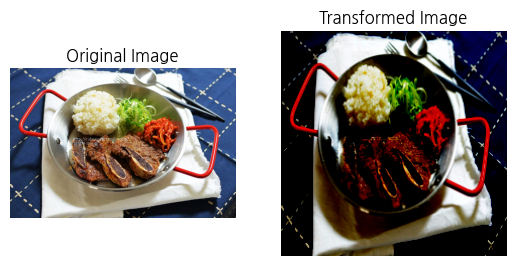

In [ ]:
# 데이터 변환 전 후를 시각화
original_image = Image.open('/content/train/갈비구이/Img_000_0002.jpg')        # 원본 이미지 로드

plt.subplot(1, 2, 1)                                                          # 변환 전 이미지 시각화
plt.title('Original Image')
plt.imshow(original_image)
plt.axis('off')

transform = transforms.Compose([                                              # 데이터 변환 설정
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

transformed_image = transform(original_image)                                 # 이미지를 변환함.

plt.subplot(1, 2, 2)                                                          # 변환 후 이미지 시각화
plt.title('Transformed Image')
plt.imshow(transformed_image.permute(1, 2, 0))                                # 이미지 텐서 형태를 시각화 형태로 변환
plt.axis('off')

plt.show()

/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


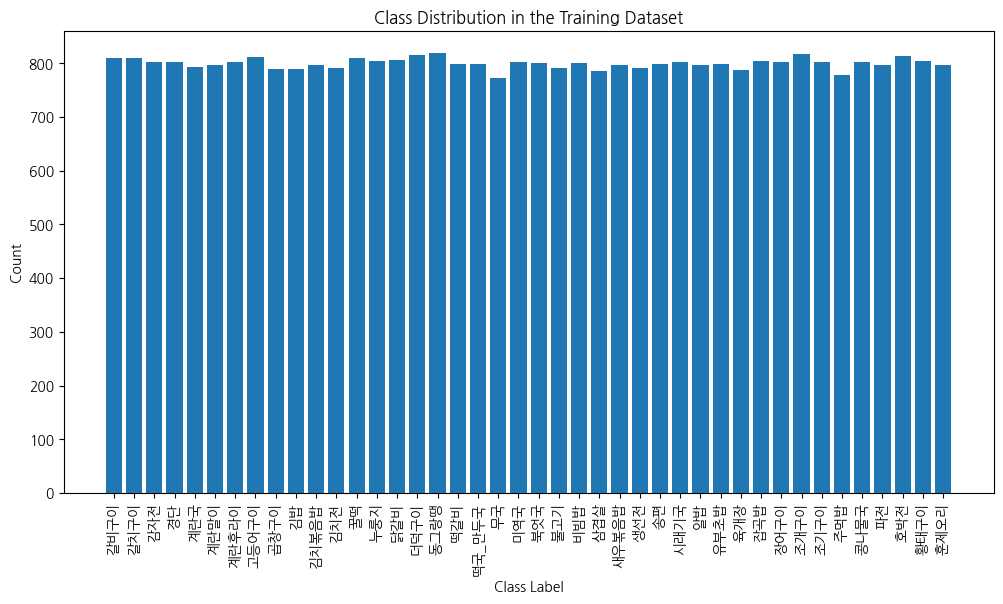

In [ ]:
# train 데이터의 분포를 알아보기 위해 시각화
class_labels = train_ds.classes               # 클래스 레이블 가져오기
class_counts = [0] * len(class_labels)

for data in train_ds:                         # 클래스별 데이터 수 계산
    _, label = data
    class_counts[label] += 1

plt.figure(figsize=(12, 6))                   # 그래프로 시각화
plt.bar(class_labels, class_counts)
plt.xticks(rotation=90)
plt.xlabel("Class Label")ㅁ
plt.ylabel("Count")
plt.title("Class Distribution in the Training Dataset")

plt.show()

In [ ]:
print(max(class_counts))    # 819
print(min(class_counts))    # 773

# 차이가 거의 나지 않으므로 언더/오버 샘플링을 하지 않는다.

819

In [ ]:
# train 데이터셋을 train, validation으로 분할
random.seed(123)

train_ratio = 0.875                                 # validation과 test의 크기를 비슷하게 하기 위해서 0.875로 설정
train_size = int(train_ratio * len(train_ds))
val_size = len(train_ds) - train_size

indices = list(range(len(train_ds)))                # 인덱스를 무작위로 섞어 무작위로 분할하도록 함
random.shuffle(indices)

train_indices = indices[:train_size]
val_indices = indices[train_size:]

train_dataset = Subset(train_ds, train_indices)
val_dataset = Subset(train_ds, val_indices)

print(len(train_dataset))
print(len(val_dataset))

29393
4200


In [ ]:
# 데이터 로더 설정
BATCH_SIZE = 16                                                                 # 미니배치 크기를 16로 정의
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)      # 검증 데이터나 테스트 데이터는 모델의 성능을 평가하는데 사용되므로 무작위성을 추가하면
test_loader = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False)          # 모델 성능 평가에 영향을 미칠 수 있으므로 shuffle=false로 지정

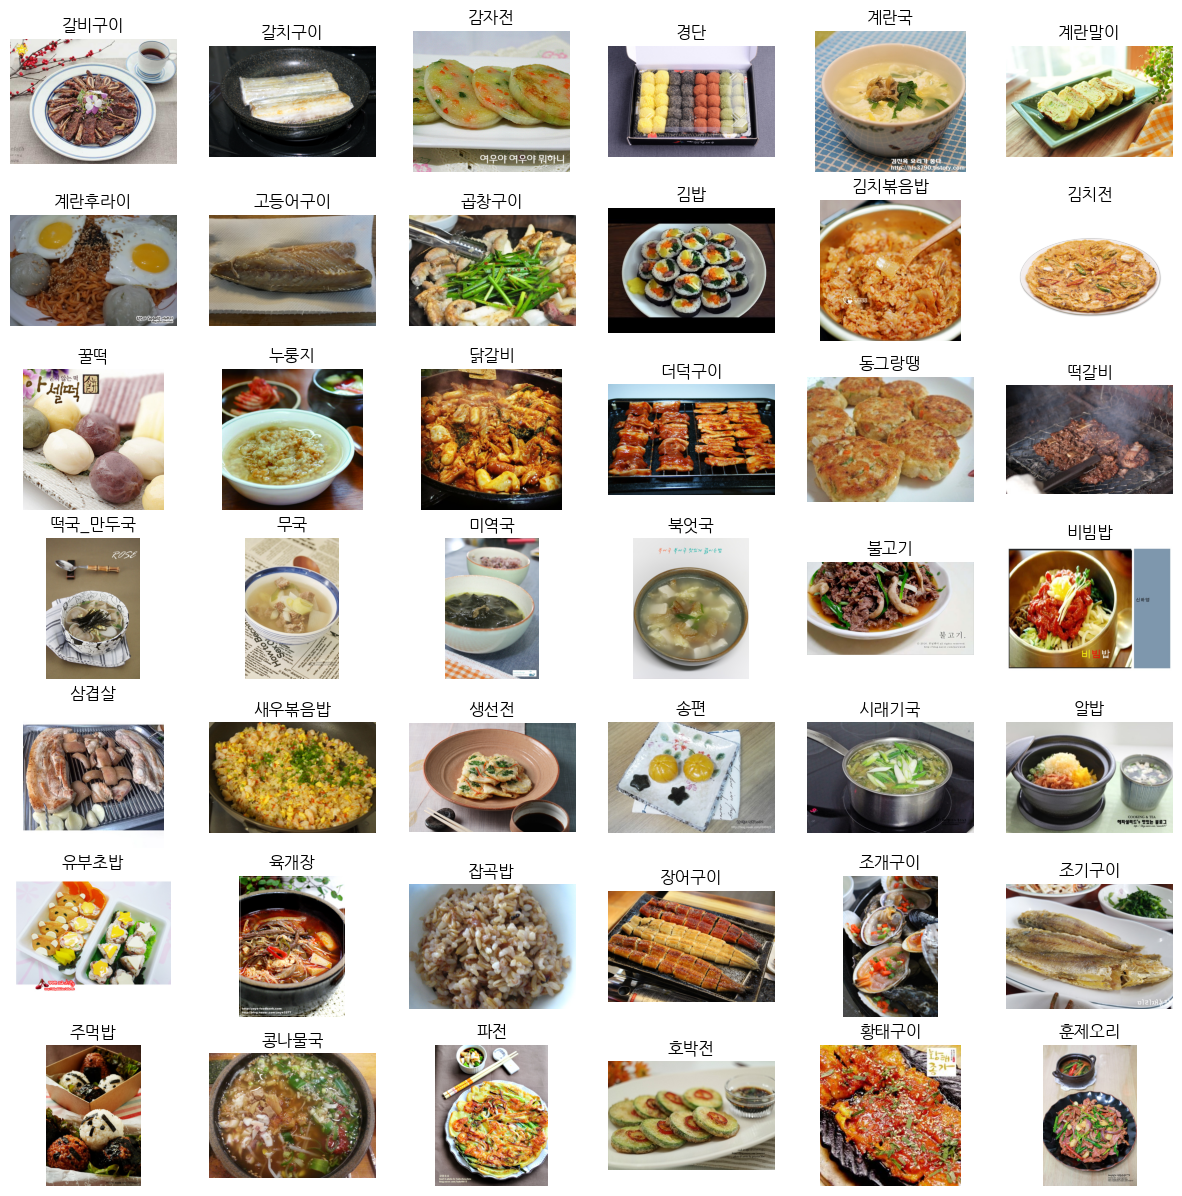

In [ ]:
# 예시 이미지를 클래스별로 하나씩 총 42장을 한번에 시각화
class_to_idx = train_ds.class_to_idx                              # 클래스 이름을 가져오기 위한 딕셔너리 생성
idx_to_class = {v: k for k, v in class_to_idx.items()}

fig, axes = plt.subplots(7, 6, figsize=(15, 15))                  # 7x6 그리드 형태로 클래스 이름과 클래스 이미지를 표시
for i, ax in enumerate(axes.flat):
    class_name = idx_to_class[i]                                  # 해당 클래스 내 첫번째 이미지 선택
    img_path = train_ds.samples[train_ds.targets.index(i)][0]
    img = Image.open(img_path)
    ax.imshow(img)
    ax.set_title(class_name)
    ax.axis('off')

plt.show()

### **MISSION 1-2.**
- ResNet18를 활용하여 42종의 클래스 분류를 수행하고 Validation 데이터에 대한 정확도를 제시한다.
- 성능 평가지표는 Top-1 accuracy를 사용한다.
- Validation accuracy 측정 시 제공된 코드를 사용한다.
- ResNet18의 parameters는 무작위로 초기화하여 사용한다. (즉, pretrained weights는 사용할 수 없다.)
- 학습 길이는 50 epoch를 기본으로 하되 추가해도 가능하다


In [ ]:
# 디바이스 및 환경 설정
DEVICE = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')   # DEVICE를 GPU가 사용 가능한 경우 'cuda'로, 그렇지 않은 경우 'cpu'로 설정.
IMG_SIZE = (224, 224)                                                                 # 이미지 크기를 (224, 224)로 정의
LEARNING_RATE = 0.001                                                                 # 학습률을 0.001로 정의
NUM_CLASSES = 42                                                                      # 클래스 수를 42로 정의
NUM_EPOCHS = 50                                                                       # 에포크 수를 50으로 정의
NUM_CPU = cpu_count()                                                                 # 사용 가능한 CPU 코어 수를 가져옴.

In [ ]:
# 모델 구축
model = torchvision.models.resnet18(pretrained = False)                     # pretrained weights를 사용할 수 없으므로 pretrained는 Fasle

num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, NUM_CLASSES)                           # model.fc 레이어의 출력 노드 수를 NUM_CLASSES로 설정하여 모델을 분류 작업에 맞게 수정

model = model.to(DEVICE)                                                    # 모델을 DEVICE로 이동

criterion = torch.nn.CrossEntropyLoss()                                     # 손실 함수를 CrossEntropy로, 최적화 알고리즘을 Adam으로 설정
optimizer = torch.optim.Adam(model.parameters(), lr = LEARNING_RATE)

summary(model, (3, IMG_SIZE[0], IMG_SIZE[1]), BATCH_SIZE)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [16, 64, 112, 112]           9,408
       BatchNorm2d-2         [16, 64, 112, 112]             128
              ReLU-3         [16, 64, 112, 112]               0
         MaxPool2d-4           [16, 64, 56, 56]               0
            Conv2d-5           [16, 64, 56, 56]          36,864
       BatchNorm2d-6           [16, 64, 56, 56]             128
              ReLU-7           [16, 64, 56, 56]               0
            Conv2d-8           [16, 64, 56, 56]          36,864
       BatchNorm2d-9           [16, 64, 56, 56]             128
             ReLU-10           [16, 64, 56, 56]               0
       BasicBlock-11           [16, 64, 56, 56]               0
           Conv2d-12           [16, 64, 56, 56]          36,864
      BatchNorm2d-13           [16, 64, 56, 56]             128
             ReLU-14           [16, 64,

In [ ]:
# 모델 학습을 위한 함수 정의
def train_model(model, criterion, optimizer, num_epochs, train_loader,val_loader):
    since = time.time()                                                                          # 훈련 시간 기록
    best_model = copy.deepcopy(model.state_dict())                                               # 가장 높은 검증 정확도를 가진 모델 가중치를 저장하기 위한 변수로 초기값은 현재 모델의 가중치로 설정
    best_acc = 0.0                                                                               # 가장 높은 검증 정확도를 저장하기 위한 변수로 초기값은 0으로 설정
    best_loss = float('inf')                                                                     # 가장 낮은 검증 손실값을 저장하기 위한 변수로 초기값은 매우 큰 값으로 설정

    train_losses = []                                                                            # 훈련 손실을 저장하기 위한 리스트
    train_accuracies = []                                                                        # 훈련 정확도를 저장하기 위한 리스트
    val_losses = []                                                                              # 검증 손실을 저장하기 위한 리스트
    val_accuracies = []                                                                          # 검증 정확도를 저장하기 위한 리스트

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch + 1, num_epochs))

        model.train()                                                                            # 모델을 학습 모드로 설정
        running_loss = 0.0                                                                       # 현재 에포크에서의 손실을 누적하는 변수로 초기값은 0으로 설정
        running_corrects = 0                                                                     # 올바르게 분류된 샘플 수를 누적하는 변수로 초기값은 0으로 설정

        for step, (inputs, labels) in enumerate(train_loader):                                   # train_loader를 순회하면서 훈련 데이터를 로드하고,
            inputs = inputs.to(DEVICE)                                                           # GPU 디바이스로 데이터를 이동시켜 forward pass 및 backward pass를 수행하여 모델을 훈련
            labels = labels.to(DEVICE)
            optimizer.zero_grad()
            with torch.set_grad_enabled(True):
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

        epoch_loss = running_loss / train_size
        epoch_acc = running_corrects.double() / train_size
        print('Train Loss: {:.4f} Train Acc: {:.4f}'.format(epoch_loss, epoch_acc))

        train_losses.append(epoch_loss)                                                          # 훈련 손실 기록
        train_accuracies.append(epoch_acc)                                                       # 훈련 정확도 기록

        model.eval()                                                                             # 모델을 평가 모드로 설정
        running_loss = 0.0                                                                       # running_loss와 running_corrects 변수를 초기화
        running_corrects = 0

        for inputs, labels in val_loader:                                                        # val_loader를 순회하면서 검증 데이터에 대한 손실과 정확도를 계산
            inputs = inputs.to(DEVICE)
            labels = labels.to(DEVICE)
            optimizer.zero_grad()                                                                # 모델의 매개변수에 대한 그래디언트(gradient)를 초기화하는 역할
            with torch.set_grad_enabled(False):
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                loss = criterion(outputs, labels)
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)
        epoch_loss = running_loss / val_size
        epoch_acc = running_corrects.double() / val_size
        print('Val Loss: {:.4f} Val Acc: {:.4f}'.format(epoch_loss, epoch_acc))
        print('-' * 30)

        val_losses.append(epoch_loss)                                                            # 검증 손실 기록
        val_accuracies.append(epoch_acc)                                                         # 검증 정확도 기록

        if epoch_acc > best_acc:                                                                 # 현재 에포크의 검증 정확도가 이전 최고 정확도(best_acc)보다 높으면,
            best_acc = epoch_acc                                                                 # 최고 정확도를 업데이트하고 모델 가중치를 지정된 경로에 저장.
            best_model = copy.deepcopy(model.state_dict())
            torch.save(best_model, '/content/drive/MyDrive/데이터 크리에이터 캠프/checkpoint/mission1.pth')

        if epoch_loss < best_loss:
            best_loss = epoch_loss

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best Val Acc: {:.4f}'.format(best_acc))
    print('Best Validation Loss: {:.4f}'.format(best_loss))
    model.load_state_dict(best_model)                                                             # 최고 모델 가중치를 모델에 로드하고, 이 모델을 반환

    return model, train_losses, train_accuracies, val_losses, val_accuracies

In [ ]:
# 모델 학습
model, train_losses, train_accuracies, val_losses, val_accuracies = train_model(model, criterion, optimizer, NUM_EPOCHS, train_loader, val_loader)

Epoch 1/50
Train Loss: 3.1276 Train Acc: 0.1471
Val Loss: 2.8562 Val Acc: 0.2162
------------------------------
Epoch 2/50
Train Loss: 2.5929 Train Acc: 0.2604
Val Loss: 2.3441 Val Acc: 0.3176
------------------------------
Epoch 3/50
Train Loss: 2.2134 Train Acc: 0.3553
Val Loss: 2.1061 Val Acc: 0.3893
------------------------------
Epoch 4/50
Train Loss: 1.9299 Train Acc: 0.4205
Val Loss: 1.9534 Val Acc: 0.4331
------------------------------
Epoch 5/50
Train Loss: 1.6882 Train Acc: 0.4885
Val Loss: 1.7509 Val Acc: 0.4850
------------------------------
Epoch 6/50
Train Loss: 1.4798 Train Acc: 0.5457
Val Loss: 1.7595 Val Acc: 0.4893
------------------------------
Epoch 7/50
Train Loss: 1.2723 Train Acc: 0.6054
Val Loss: 1.5042 Val Acc: 0.5762
------------------------------
Epoch 8/50
Train Loss: 1.0831 Train Acc: 0.6620
Val Loss: 1.3426 Val Acc: 0.6086
------------------------------
Epoch 9/50
Train Loss: 0.8782 Train Acc: 0.7213
Val Loss: 1.4475 Val Acc: 0.5905
-----------------------

In [ ]:
# accuracy, loss 그래프 출력하는 함수 정의
def plot_training_history(train_losses, val_losses, train_accuracies, val_accuracies):
    plt.figure(figsize=(12, 6))                               # loss 그래프 출력
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    # Plot Accuracy
    plt.subplot(1, 2, 2)                                      # accuracy 그래프 출력
    plt.plot(train_accuracies, label='Training Accuracy')
    plt.plot(val_accuracies, label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.show()

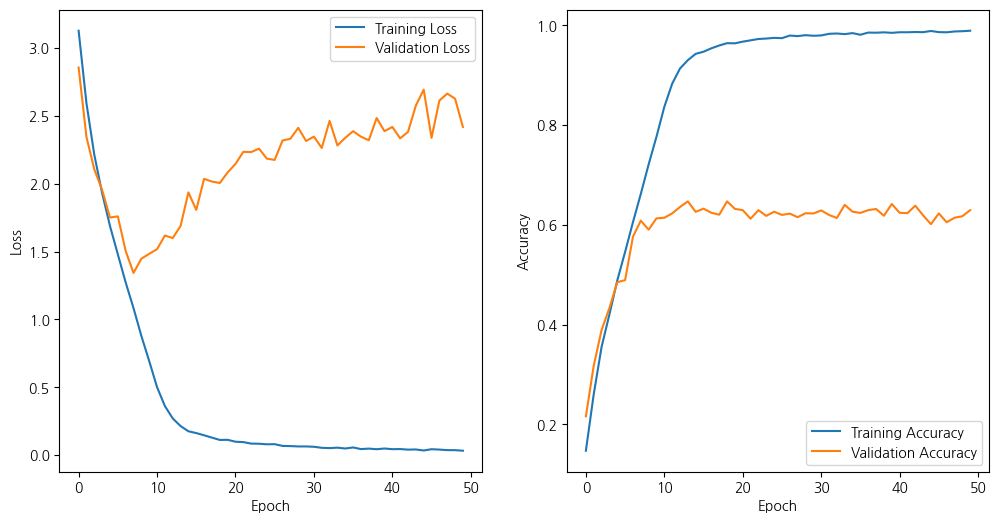

In [ ]:
# accuracy, loss 그래프 출력
train_accuracies = [acc.to('cpu') for acc in train_accuracies]                      #  train_accuracies, val_accuracies는 CPU로 이동시킨 후 사용
val_accuracies = [acc.to('cpu') for acc in val_accuracies]

plot_training_history(train_losses, val_losses, train_accuracies, val_accuracies)

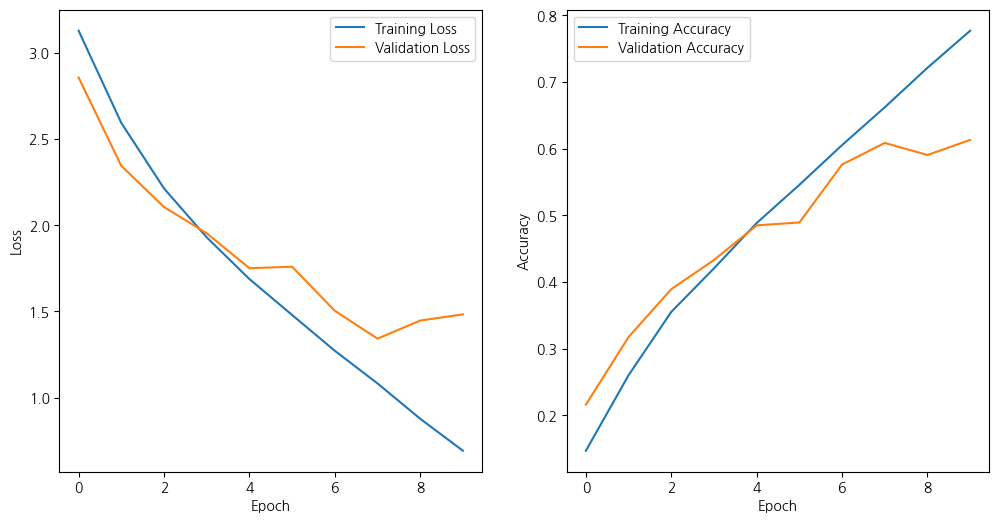

In [ ]:
# 10 에폭까지의 데이터만 그래프로 표시 (나중에 정규화 기법 비교를 위해)
plot_training_history(train_losses[:10], val_losses[:10], train_accuracies[:10], val_accuracies[:10])

In [ ]:
# Validation accuracy 측정 함수 정의 (제공된 코드 사용)
@torch.no_grad()
def validate_epoch(model, data_loader, device):
    model.eval()
    accuracies = []
    for images, labels in tqdm(data_loader, total=len(data_loader), mininterval=1, desc='measuring accuracy'):
        images = images.to(device)
        labels = labels.to(device)

        logits = model(images)
        pred = torch.argmax(logits, dim=1)

        accuracies.append(pred == labels)

    accuracy = torch.cat(accuracies).float().mean() * 100
    return accuracy.item()

In [ ]:
# 정확도 측정
test_accuracy = validate_epoch(model, test_loader, DEVICE)
print(f'\ntest Accuracy: {test_accuracy:.2f}%')

measuring accuracy: 100%|██████████| 263/263 [00:36<00:00,  7.25it/s]


test Accuracy: 64.10%


In [ ]:
# 혼동행렬 출력 함수 정의
def plot_confusion_matrix(model, data_loader, device):
    model.eval()
    y_true = []
    y_pred = []

    for inputs, labels in tqdm(data_loader, total=len(data_loader), desc='Creating Confusion Matrix'):
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)

        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())

    cm = confusion_matrix(y_true, y_pred)

    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")
    plt.title("Confusion Matrix")
    plt.show()

Creating Confusion Matrix: 100%|██████████| 263/263 [00:37<00:00,  7.10it/s]


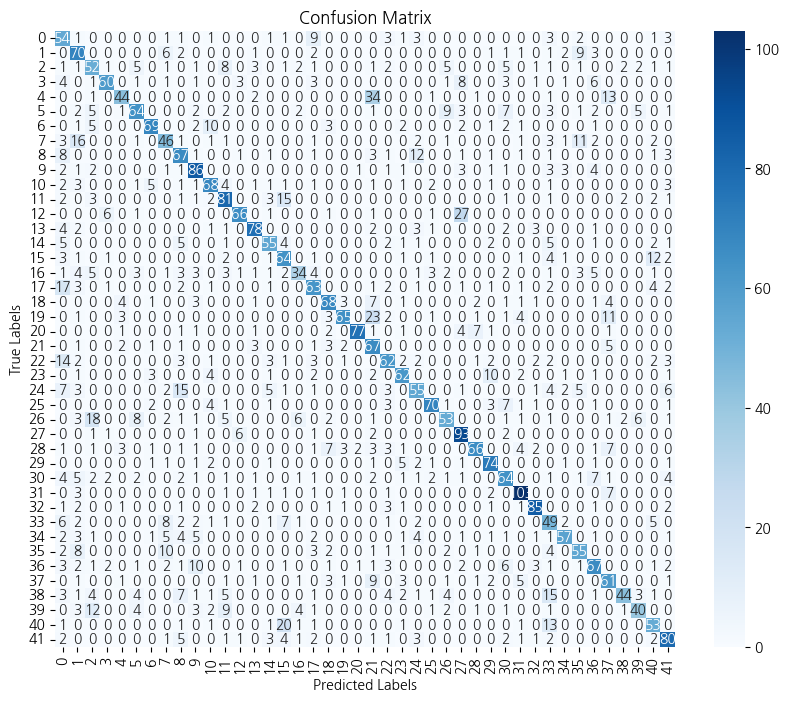

In [ ]:
# 혼동행렬 출력
plot_confusion_matrix(model, test_loader, DEVICE)